**Travelling salesman or TSP problem**

"Given a list of cities and their distance between each other, what is the shortest route that visits each city ONCE before returning to the starting city (depot)?"

The TSP can be modeled as Integer Linear Program.
Notable formulations: Miller–Tucker–Zemlin (MTZ), Dantzig–Fulkerson–Johnson (DFJ).

**Import the libraries**

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pulp import *
from scipy.spatial import distance_matrix

**Import example data**

In [2]:
data = pd.read_excel("data/tsp_data.xlsx")
data.head(3)

,osmid,name,rank,x_poi,y_poi,LUN,MAR,MER,GIO,VEN,...,T17_00,T18_00,T19_00,T20_00,T21_00,T22_00,T23_00,GRID_ID,grid_x,grid_y
0,597452722,Ambiente 4,0.100000,789548.4072,4.643460e+06,09:30-19:15,09:30-19:15,09:30-19:15,09:30-19:15,09:30-19:15,...,118,135,132,142,107,69,48,E-4,789485.8791,4.643502e+06
1,1835450,Ambiente 4,0.100000,789522.8022,4.643475e+06,09:30-19:15,09:30-19:15,09:30-19:15,09:30-19:15,09:30-19:15,...,118,135,132,142,107,69,48,E-4,789485.8791,4.643502e+06
2,1841077,Arco di Augusto,0.392381,789233.9026,4.643661e+06,00:00-23:59,00:00-23:59,00:00-23:59,00:00-23:59,00:00-23:59,...,238,243,198,163,112,77,58,D-3,789163.5082,4.643689e+06


**Getting x, y cooordinates of the points (x_poi and y_poi)**

In [3]:
# set a random number of points to analyze
# don't use large numbers or PuLP is gonna fail
N = 10

# define points interator once
points_iter = range(N)

# select random data to analyze from the df
coord = data[["x_poi", "y_poi"]].sample(n=N)
coord.columns = ["x", "y"]
coord.reset_index(inplace=True, drop=True)

# calculate the distance matrix
dist_mat = distance_matrix(coord.values, coord.values)
np.fill_diagonal(dist_mat, 9999)
print("\nDistance matrix:\n", dist_mat[:2])


Distance matrix:
 [[9999.          196.28113624   83.53898726  483.31458326  555.47280511
   438.82909705  472.73572963  291.68039612  376.38871045  531.3241439 ]
 [ 196.28113624 9999.          231.99421524  330.85004566  388.42487782
   254.46676121  284.86893999  103.18942048  291.06897365  351.72887815]]


**Visualizing the points**

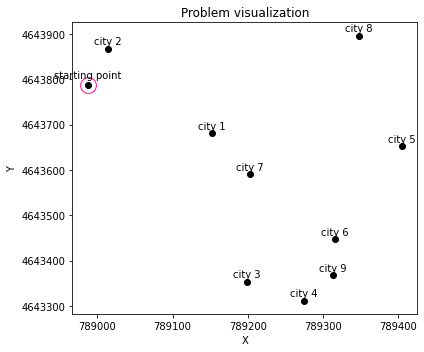

In [4]:
fig, ax = plt.subplots(figsize=(6, 5))

# plot data using scatter plot
ax.scatter(coord["x"], coord["y"], color="k")

# Circle the starting point
ax.scatter(coord["x"][0], coord["y"][0], s=250, 
           c=np.array([[0,0,0,0]]), edgecolors="deeppink")

# annotate points
offset = 10
for i, (x, y) in enumerate(zip(coord["x"], coord["y"])):
      text = "starting point"
      if i != 0:
            offset = 5
            text = f"city {i}"
      ax.text(x=x, y=y+offset, s=text, va="bottom", ha="center")

# disable offset and scientific notation of the axis
ax.ticklabel_format(useOffset=False, style="plain")

# set titles
ax.set_title("Problem visualization")
ax.set_xlabel("X")
ax.set_ylabel("Y")

fig.tight_layout()
plt.show()

**The LP model is explained as follows:**

- N = Number of location including depot
- $C_{i,j}$ = edge cost from node i to node j, where $i,j= [1…N]$
- Decision variable: $X_{i,j} = 1$, if solution has direct path from node i to j, otherwise 0 ($X_{i,i} = 0$)

The **objective** is to minimize the route. Constraints (2) and (3) ensures that there is only one outflow and inflow edge for each node, respectively. Constraint (4) restricts outflow to one’s own node (i.e. each node is visited only once).

- (1) MIN $C_{i,j}X_{i,j}$, where $C_{i,j}$ is the distances matrix (<-- objective)
- (2) $\sum X_{i,j} = 1$ (j=1 to N), $i=1...N$
- (3) $\sum X_{i,j} = 1$ (i=1 to N), $J=1...N$
- (4) $X_{i,i} = 0, i=1...N$

**To eliminate subtours**, continuous decision variables representing times at which a location is visited is added.

Continuous variable for all locations except the start node is added.

$Uj > Ui$, if $X_{i,j} = 1$

i.e.

$Uj >= Ui - B(1 - X_{i,j})$ for some large value of B

This formulation was proposed by Miller–Tucker–Zemlin (MTZ).

Definition of the problem in PuLP

PuLP library is used for implementing MILP model in python.

https://pypi.org/project/PuLP/

PuLP is an LP modeler written in Python. PuLP can generate MPS or LP files and call GLPK, COIN-OR CLP/CBC, CPLEX, GUROBI, MOSEK, XPRESS, CHOCO, MIPCL, SCIP to solve linear problems.

In [5]:
# it is a minimization problem
problem = LpProblem("MTZ", LpMinimize)

# define X variable 
X = LpVariable.dicts("X",((i,j) for i in points_iter for j in points_iter), cat="Binary")

# define U continuous variable for subtour elimination
U = LpVariable.dicts("U", (i for i in points_iter), lowBound=1, upBound=N, cat = "Integer")

problem += lpSum(dist_mat[i][j] * X[i,j] for i in points_iter for j in points_iter)

for i in points_iter:
    # since we are iterating over i iterate over j
    problem += lpSum(X[i,j] for j in points_iter) == 1  #(1)
    problem += lpSum(X[j,i] for j in points_iter) == 1  #(2)

    # restrict outflow to one’s own node
    problem += X[i,i] == 0  #(4)

    # eliminate subtours
    for j in points_iter:
        if i != j and (i != 0 and j != 0):
            problem += U[i] - U[j] + N * X[i,j] <= N - 1

status = problem.solve()
print(status, LpStatus[status], pulp.value(problem.objective))

1 Optimal 1663.1528698845896


**Getting the resulting nodes and visualize the problem**

In [6]:
route = [(i,j) for i in points_iter for j in points_iter if pulp.value(X[i,j]) == 1]

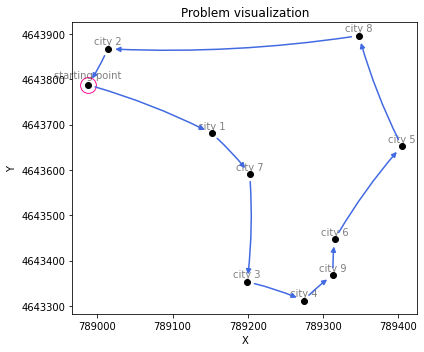

In [7]:
fig, ax = plt.subplots(figsize=(6, 5))

# plot data using scatter plot
ax.scatter(coord["x"], coord["y"], color="k")

# Circle the starting point
ax.scatter(coord["x"][0], coord["y"][0], s=250, 
           c=np.array([[0,0,0,0]]), edgecolors="deeppink")

# annotate points
offset = 10
for i, (x, y) in enumerate(zip(coord["x"], coord["y"])):
      text = "starting point"
      if i != 0:
            offset = 5
            text = f"city {i}"
      ax.text(x=x, y=y+offset, s=text, va="bottom", ha="center", color="k", alpha=0.50)

# show the route
arrowprops = dict(arrowstyle="-|>", connectionstyle="arc3,rad=-0.05",
                  shrinkA=7.5, shrinkB=7.5, linewidth=1.5, color="royalblue")
for i, j in route:
    ax.annotate("",
                xy=[coord.iloc[j]["x"],
                coord.iloc[j]["y"]],
                xytext=[coord.iloc[i]["x"],
                coord.iloc[i]["y"]],
                arrowprops=arrowprops,
                zorder=5)

# disable offset and scientific notation of the axis
ax.ticklabel_format(useOffset=False, style="plain")

# set titles
ax.set_title("Problem visualization")
ax.set_xlabel("X")
ax.set_ylabel("Y")

fig.tight_layout()
plt.show()